In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from scipy.signal import savgol_filter
from yellowbrick.regressor import ResidualsPlot

In [2]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (data_msc, ref)

# Banco de dados wheat: Espectros NIR de 100 amostras de FLOUR. Faixa de comprimento de onda de 1101 a 2502 nm com 2 nm de intervalo (701 preditores)

Respostas: moisture e protein
 
x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.

x702 - x703 = Matriz de respostas 

In [3]:
annots = loadmat('Datasets/wheat.mat')                  # Carregar o arquivo wheat.mat
df_wheat = pd.DataFrame(annots['wheat'])                # Transformar em um dataframe

df_wheat.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,693,694,695,696,697,698,699,700,701,702
64,0.326525,0.325949,0.325299,0.324780,0.324313,0.323836,0.323504,0.323179,0.323005,0.322937,...,1.027431,1.028844,1.030392,1.031661,1.033005,1.033935,1.034338,1.035018,11.64,15.81
19,0.278783,0.278203,0.277458,0.276870,0.276314,0.275790,0.275359,0.274975,0.274637,0.274460,...,0.959756,0.961528,0.962617,0.963872,0.964593,0.965293,0.965587,0.965928,10.74,13.37
67,0.329226,0.328644,0.328037,0.327485,0.326985,0.326522,0.326187,0.325869,0.325686,0.325587,...,1.100758,1.102172,1.103830,1.104832,1.105883,1.106891,1.107073,1.107902,11.07,15.34


## Visualização da espectrometria

In [4]:
y = [0]*2                                                   # Lista de 
X = df_wheat.iloc[:,:700].values                            # x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.
y[0] = df_wheat.iloc[:,701].values                         # 701 = Moisture
y[1] = df_wheat.iloc[:,702].values                         # 702 = Protein   

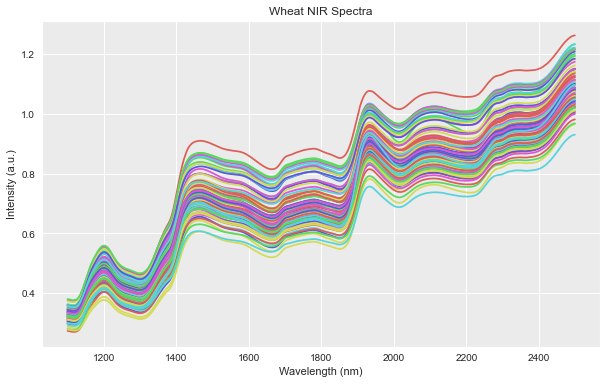

In [5]:
import warnings
warnings.filterwarnings('ignore')

wl = np.arange(1101,2500,2)
plt.figure(figsize=(10,6))

for idx, line in enumerate(X):
    sns.set_palette("hls")#, n_colors=15)

    sns.set_style('darkgrid', {'axes.facecolor': '0.92'})
    sns.lineplot(wl, line.T)

# bigger plot
plt.title('Wheat NIR Spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.show()

## Remoção do ruído de base usando filtro Savitzky Golay

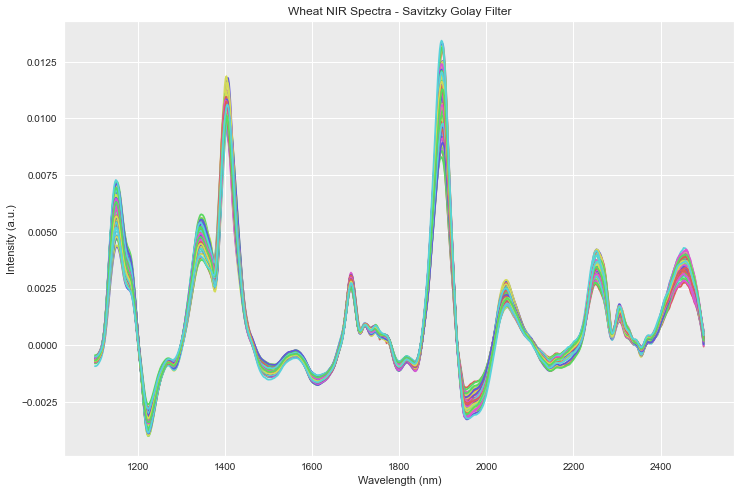

In [6]:
# Multiplicative Scatter Correction
Xc, ref = msc(X)
# First Derivative Smoothing
Xc = savgol_filter(Xc,11,3, deriv=1)
plt.figure(figsize=(12,8))

for idx, line in enumerate(Xc):
    sns.set_palette("hls")

    sns.set_style('darkgrid', {'axes.facecolor': '0.92'})
    sns.lineplot(wl, line.T)

# bigger plot
plt.title('Wheat NIR Spectra - Savitzky Golay Filter')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.show()

## Pré-processamento e normalização

In [14]:

sc = RobustScaler()                                      # Instancia do robust scaler, para normalizar os dados - usa mediana e desvio padrão
y_test, y_train = [0]*2, [0]*2

for i in range (2):

    #train_test spli - escolhido 25% como teste
    X_train, X_test, y_train[i], y_test[i] = train_test_split(
                                                        Xc, y[i], 
                                                        test_size=0.25, 
                                                        random_state=22
                                                        )



X_train = sc.fit_transform(X_train)                     # Normalização dos dados de treino - fit
X_test = sc.transform(X_test)                           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

# MOISTURE
y_train[0] = sc.fit_transform(np.array(y_train[0]).reshape(-1,1))     # Normalização dos dados de treino - fit
y_test[0] = sc.transform(np.array(y_test[0]).reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

# PROTEIN
y_train[1] = sc.fit_transform(np.array(y_train[1]).reshape(-1,1))     # Normalização dos dados de treino - fit
y_test[1] = sc.transform(np.array(y_test[1]).reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

## Iteração pelo número de componentes para encontrar menor valor de erro

MSE mínimo: 0.13 foi atingido com n_components = 13 para a variável Moisture
R2 score da regressão com 13 componentes para a variável Moisture: 0.91
MSE mínimo: 0.01 foi atingido com n_components = 5 para a variável Proteína
R2 score da regressão com 5 componentes para a variável Proteína: 0.98


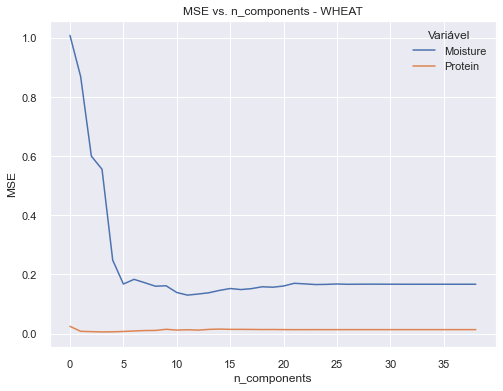

In [15]:
# muitos avisos de deprecação
import warnings
warnings.filterwarnings('ignore')

pls = [0]*100                                                     # Inicia vetor com PLS de 1 a 100 componentes
mse = [0]*100                                                     # Inicia vetor de erro para guardar cada um dos erros da regressão PLS


for n in range (1,100):                                           # Loop para calcular o erro para cada número de componentes

    pls[n] = PLSRegression(n_components=n)                        # Instancia o modelo PLS com n componentes
    pls[n].fit(X_train, y_train[0])                                  # Faz a regressão
    mse[n] = mean_squared_error(y_test[0], pls[n].predict(X_test))   # Calcula o erro   
mse[0] = mse[1]                                                   # tratamento para evitar o erro na hora de avaliar o mínimo MSE


sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
ax = plt.plot(mse[1:40])                          # Plota o gráfico de erro
plt.title('MSE vs. n_components')                                 # Define o título do gráfico  
plt.xlabel('n_components')                                        # Define o título do eixo x
plt.ylabel('MSE')                                                 # Define o título do eixo y


# Printa o número de componentes e o erro mínimo
print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável Moisture'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1))
print('R2 score da regressão com {0} componentes para a variável Moisture: {1:.2f}'.format(mse.index(min(mse[1:40]))+1, r2_score(y_test[0], pls[mse.index(min(mse[1:40]))+1].predict(X_test))))
#print('\n') 

n_components_moisture = mse.index(min(mse[1:40]))+1              # Guarda o número de componentes para a variável Moisture

for n in range (1,100):                                           # Loop para calcular o erro para cada número de componentes

    pls[n] = PLSRegression(n_components=n)                        # Instancia o modelo PLS com n componentes
    pls[n].fit(X_train, y_train[1])                                  # Faz a regressão
    mse[n] = mean_squared_error(y_test[1], pls[n].predict(X_test))   # Calcula o erro   
mse[0] = mse[1]                                                   # tratamento para evitar o erro na hora de avaliar o mínimo MSE

# Printa o número de componentes e o erro mínimo
print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável Proteína'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1))
print('R2 score da regressão com {0} componentes para a variável Proteína: {1:.2f}'.format(mse.index(min(mse[1:40]))+1, r2_score(y_test[1], pls[mse.index(min(mse[1:40]))+1].predict(X_test))))

n_components_protein = mse.index(min(mse[1:40]))+1                 # Guarda o número de componentes para a variável Protein

sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
ax = plt.plot(mse[1:40])                                          # Plota o gráfico de erro
plt.title('MSE vs. n_components - WHEAT')                                 # Define o título do gráfico  
plt.xlabel('n_components')                                        # Define o título do eixo x
plt.ylabel('MSE')

plt.legend(title='Variável', loc='upper right', labels=['Moisture', 'Protein'])
    

    # Printa o número de componentes e o erro mínimo
      

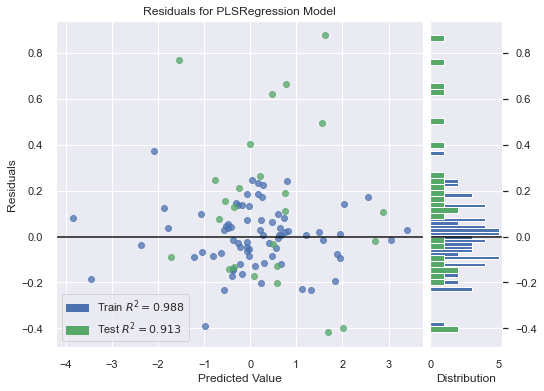

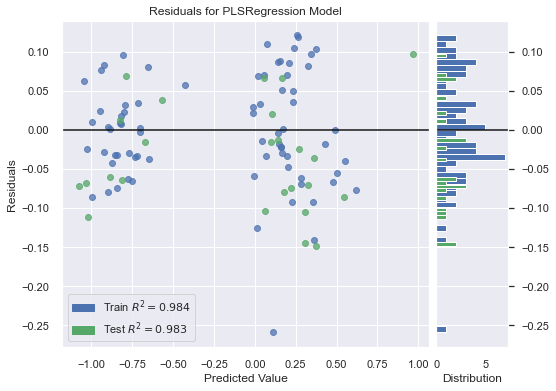

In [33]:
pls_wheat, residuals_viz = [0]*2, [0]*2	
pls_wheat[0] = PLSRegression(n_components=n_components_moisture)     
pls_wheat[1] = PLSRegression(n_components=n_components_protein)

var_list = ['Moisture', 'Protein']

for i in range(2):
    residuals_viz[i] = ResidualsPlot(pls_wheat[i])
    residuals_viz[i].fit(X_train, y_train[i])
    residuals_viz[i].score(X_test, y_test[i])
    residuals_viz[i].show()




# Corn Dataset


In [50]:
annots = loadmat('Datasets/corn_mp5.mat')                  # Carregar o arquivo wheat.mat

df_corn_features = pd.DataFrame(annots['mp6spec'][0][0][7])
df_corn_results = pd.DataFrame(annots['propvals'])
                               
df_corn_features.sample(3) 

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
59,-0.021187,-0.021291,-0.021365,-0.021406,-0.021400,-0.021353,-0.021217,-0.021030,-0.020715,-0.020313,...,0.706256,0.707866,0.709107,0.710078,0.710825,0.711080,0.711059,0.710852,0.710450,0.709741
15,-0.007647,-0.007723,-0.007793,-0.007831,-0.007798,-0.007735,-0.007606,-0.007367,-0.007014,-0.006521,...,0.795746,0.797310,0.798563,0.799616,0.800334,0.800700,0.800767,0.800534,0.800240,0.799614
71,-0.022869,-0.022955,-0.023014,-0.023045,-0.023035,-0.022997,-0.022876,-0.022720,-0.022444,-0.022099,...,0.698064,0.699662,0.700954,0.701999,0.702714,0.703101,0.703204,0.702914,0.702445,0.701656


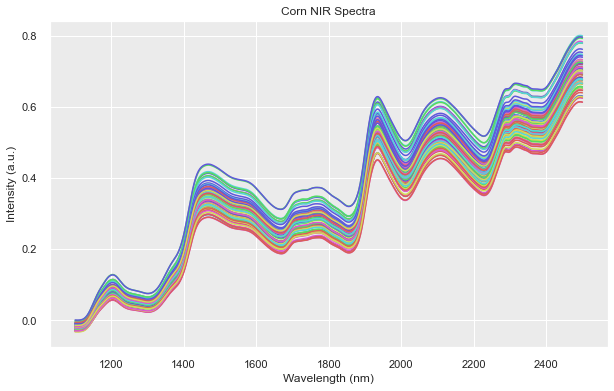

In [51]:
X = df_corn_features.iloc[:,:].values                    # x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.

wl = np.arange(1101,2500,2)
plt.figure(figsize=(10,6))

for idx, line in enumerate(X):
    sns.set_palette("hls")#, n_colors=15)

    sns.set_style('darkgrid', {'axes.facecolor': '0.92'})
    sns.lineplot(wl, line.T)

# bigger plot
plt.title('Corn NIR Spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.show()


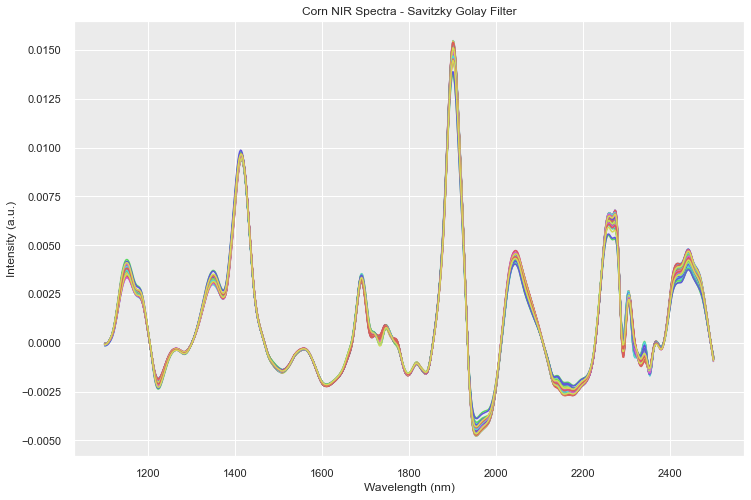

In [52]:
# Multiplicative Scatter Correction
Xc, ref = msc(X)
# First Derivative Smoothing
Xc = savgol_filter(Xc,11,3, deriv=1)
plt.figure(figsize=(12,8))

for idx, line in enumerate(Xc):
    sns.set_palette("hls")

    sns.set_style('darkgrid', {'axes.facecolor': '0.92'})
    sns.lineplot(wl, line.T)

# bigger plot
plt.title('Corn NIR Spectra - Savitzky Golay Filter')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.show()

## Pré-processamento e normalização

In [53]:
sc = RobustScaler()                                      # Instancia do robust scaler, para normalizar os dados - usa mediana e desvio padrão
y, y_train, y_test, n_components = [0]*4, [0]*4, [0]*4, [0]*4                                # Inicializa a lista de resultados   



for i in range (4):
    y[i] = df_corn_results.iloc[:, i].values               # Loop para cada resultado:  
    #train_test spli - escolhido 25% como teste
    X_train, X_test, y_train[i], y_test[i] = train_test_split(
                                                    X, y[i], 
                                                    test_size=0.25, 
                                                    random_state=27
                                                    )
    y_train[i] = sc.fit_transform(y_train[i].reshape(-1,1))     # Normalização dos dados de treino - fit
    y_test[i] = sc.transform(y_test[i].reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage


X_train = sc.fit_transform(X_train)                     # Normalização dos dados de treino - fit
X_test = sc.transform(X_test)                           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage


## Regressão PLS

MSE mínimo: 0.04 foi atingido com n_components = 14 para a variável de saída n1
R2 score da regressão com 14 componentes para a variável de saida n1: 0.93
MSE mínimo: 0.17 foi atingido com n_components = 19 para a variável de saída n2
R2 score da regressão com 19 componentes para a variável de saida n2: 0.83
MSE mínimo: 0.03 foi atingido com n_components = 15 para a variável de saída n3
R2 score da regressão com 15 componentes para a variável de saida n3: 0.93
MSE mínimo: 0.13 foi atingido com n_components = 9 para a variável de saída n4
R2 score da regressão com 9 componentes para a variável de saida n4: 0.76


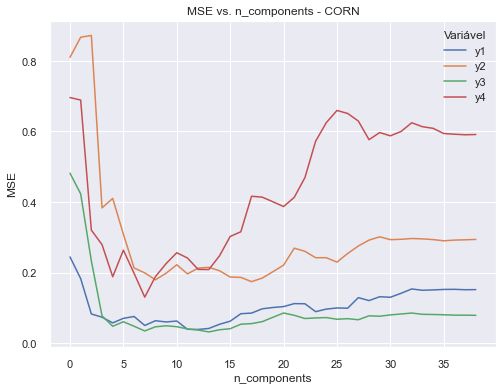

In [54]:
import warnings
warnings.filterwarnings('ignore')

pls = [0]*100                                                     # Inicia vetor com PLS de 1 a 100 componentes
mse = [0]*100                                                     # Inicia vetor de erro para guardar cada um dos erros da regressão PLS

for i in range(4):
    for n in range (1,100):                                              # Loop para calcular o erro para cada número de componentes

        pls[n] = PLSRegression(n_components=n)                           # Instancia o modelo PLS com n componentes
        pls[n].fit(X_train, y_train[i])                                  # Faz a regressão
        mse[n] = mean_squared_error(y_test[i], pls[n].predict(X_test))   # Calcula o erro   
    mse[0] = mse[1]                                                      # tratamento para evitar o erro na hora de avaliar o mínimo MSE


    sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
    ax = plt.plot(mse[1:40])                          # Plota o gráfico de erro
    plt.title('MSE vs. n_components - CORN')                          # Define o título do gráfico  
    plt.xlabel('n_components')                                        # Define o título do eixo x
    plt.ylabel('MSE')                                                 # Define o título do eixo y
    plt.legend(title='Variável', loc='upper right', labels=['y1', 'y2', 'y3', 'y4'])
    

    # Printa o número de componentes e o erro mínimo
    print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável de saída n{2}'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1, i+1))
    print('R2 score da regressão com {0} componentes para a variável de saida n{1}: {2:.2f}'.format(mse.index(min(mse[1:40]))+1, i+1, r2_score(y_test[i], pls[mse.index(min(mse[1:40]))+1].predict(X_test))))
    n_components[i] = mse.index(min(mse[1:40]))+1
 

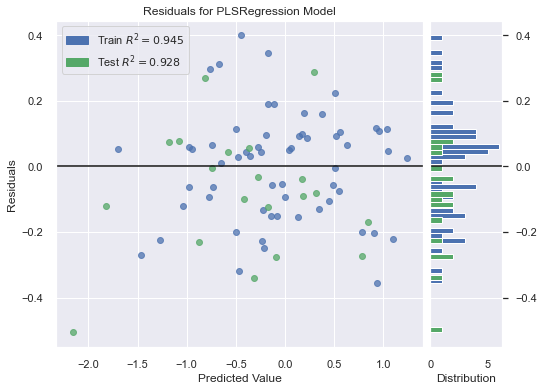

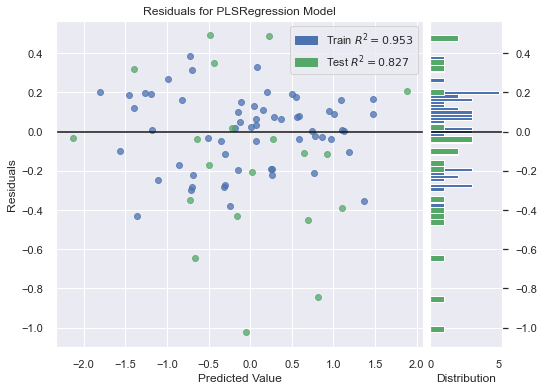

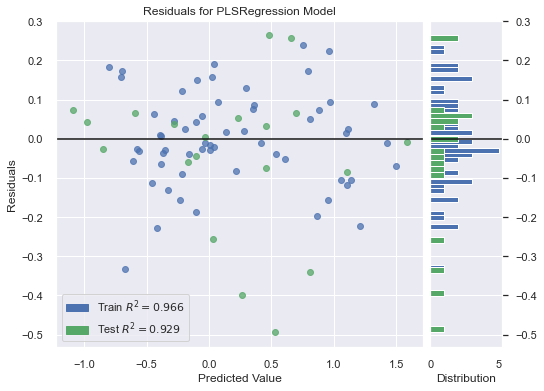

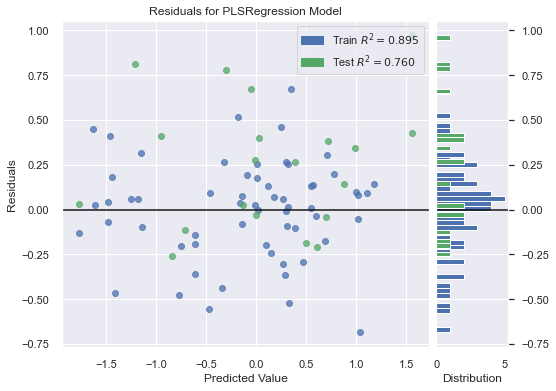

In [61]:
pls_corn, residuals_viz = [0]*4, [0]*4	

for i in range(4):
    pls_corn[i] = PLSRegression(n_components=n_components[i])   
    residuals_viz[i] = ResidualsPlot(pls_corn[i])
    residuals_viz[i].fit(X_train, y_train[i])
    residuals_viz[i].score(X_test, y_test[i])
    residuals_viz[i].show()

# Chemometrics Article

In [9]:
df_chemometrics = pd.read_csv("Datasets/chemometrics.csv", sep=';', index_col='Unnamed: 0')

df_chemometrics.sample(19)

,PIE,PIF,DGR,SAC,MR,Lam,Vol,DDGTS
Asp,-0.61,-0.77,1.20,287.9,2.994,-1.08,103.7,8.5
His,0.15,0.13,-0.25,337.2,3.856,-1.06,140.6,10.1
Asn,-0.48,-0.60,0.51,303.6,2.994,-1.24,112.3,8.2
Ser,0.00,-0.04,0.09,266.7,2.279,-0.40,88.5,7.4
Ile,1.20,1.80,-2.10,322.6,3.350,0.04,131.7,16.8
Tyr,0.89,0.96,-1.70,377.8,4.791,-0.84,162.7,8.8
Pro,0.38,0.49,-1.50,288.5,2.876,-0.31,106.7,8.2
Cys,0.45,1.54,-1.40,282.9,2.933,-0.11,99.1,11.0
Glu,-0.51,-0.64,0.76,311.6,3.243,-1.43,120.5,8.8
Val,0.71,1.22,-1.60,295.1,3.054,-0.13,115.6,12.0


In [10]:
df_chemometrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, Ala to Val
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PIE     19 non-null     float64
 1   PIF     19 non-null     float64
 2   DGR     19 non-null     float64
 3   SAC     19 non-null     float64
 4   MR      19 non-null     float64
 5   Lam     19 non-null     float64
 6   Vol     19 non-null     float64
 7   DDGTS   19 non-null     float64
dtypes: float64(8)
memory usage: 1.3+ KB


In [11]:
df_chemometrics.describe()

,PIE,PIF,DGR,SAC,MR,Lam,Vol,DDGTS
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.383684,0.548421,-0.786842,312.457895,3.319105,-0.584211,121.642105,9.884211
std,0.751385,0.994145,1.215557,43.485442,0.967395,0.641520,29.352746,2.757870
min,-0.770000,-0.990000,-2.700000,224.900000,1.662000,-2.260000,65.000000,6.300000
25%,-0.055000,-0.130000,-1.650000,285.900000,2.904500,-1.070000,104.500000,8.200000
50%,0.230000,0.310000,-0.580000,311.600000,3.054000,-0.330000,120.500000,8.800000
75%,0.895000,1.385000,0.190000,336.450000,3.687000,-0.080000,136.450000,11.100000
max,1.850000,2.250000,1.200000,401.800000,5.755000,0.120000,185.900000,16.800000


In [12]:
X = df_chemometrics.iloc[:, :7].values
y = df_chemometrics.iloc[:, 7].values

sc = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = sc.fit_transform(y_train.reshape(-1,1))
y_test = sc.transform(y_test.reshape(-1,1))


MSE mínimo: 0.67 foi atingido com n_components = 5
R2 score da regressão com 5 componentes: 0.51
[1.2362885587633754, 1.2362885587633754, 1.1920545288137139, 0.8698913374310167, 0.7388882792961465, 0.6657448614218802, 0.8930053649685146, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604, 0.7663381140577604]


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cross_decomposition\_pls.py:230: FutureWarning: As of version 0.24, n_components(8) should be in [1, n_features].n_components=7 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cross_decomposition\_pls.py:230: FutureWarning: As of version 0.24, n_components(9) should be in [1, n_features].n_components=7 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cross_decomposition\_pls.py:230: FutureWarning: As of version 0.24, n_components(10) should be in [1, n_feature

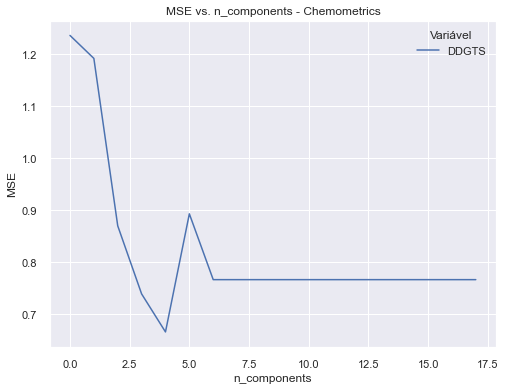

In [25]:
pls, mse = [0]*19, [10]*19

for n in range (1,19):                                              # Loop para calcular o erro para cada número de componentes




    pls[n] = PLSRegression(n_components=n)                           # Instancia o modelo PLS com n componentes
    pls[n].fit(X_train, y_train)                                  # Faz a regressão
    mse[n] = mean_squared_error(y_test, pls[n].predict(X_test))   # Calcula o erro   
mse[0] = mse[1]                                                      # tratamento para evitar o erro na hora de avaliar o mínimo MSE

sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
ax = plt.plot(mse[1:19])                          # Plota o gráfico de erro
plt.title('MSE vs. n_components - Chemometrics')                          # Define o título do gráfico  
plt.xlabel('n_components')                                        # Define o título do eixo x
plt.ylabel('MSE')                                                 # Define o título do eixo y
plt.legend(title='Variável', loc='upper right', labels=['DDGTS'])

# Printa o número de componentes e o erro mínimo
print('MSE mínimo: {0:.2f} foi atingido com n_components = {1}'.format(min(mse[1:19]), mse.index(min(mse[1:19]))))
print('R2 score da regressão com {0} componentes: {1:.2f}'.format(mse.index(min(mse[1:19])), r2_score(y_test, pls[mse.index(min(mse[1:19]))].predict(X_test))))

print(mse)
n_components = mse.index(min(mse[1:19]))

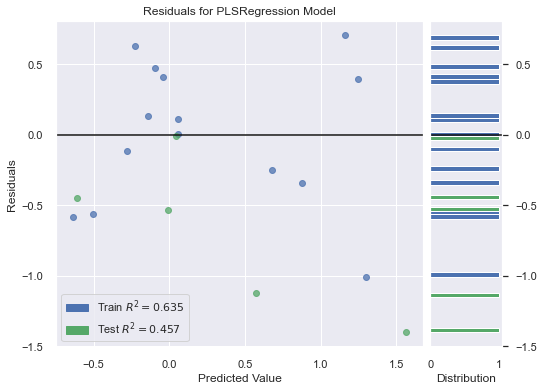

<AxesSubplot:title={'center':'Residuals for PLSRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [24]:
pls_chemometrics = PLSRegression(n_components=n_components)   
residuals_viz = ResidualsPlot(pls_chemometrics)
residuals_viz.fit(X_train, y_train)
residuals_viz.score(X_test, y_test)
residuals_viz.show()

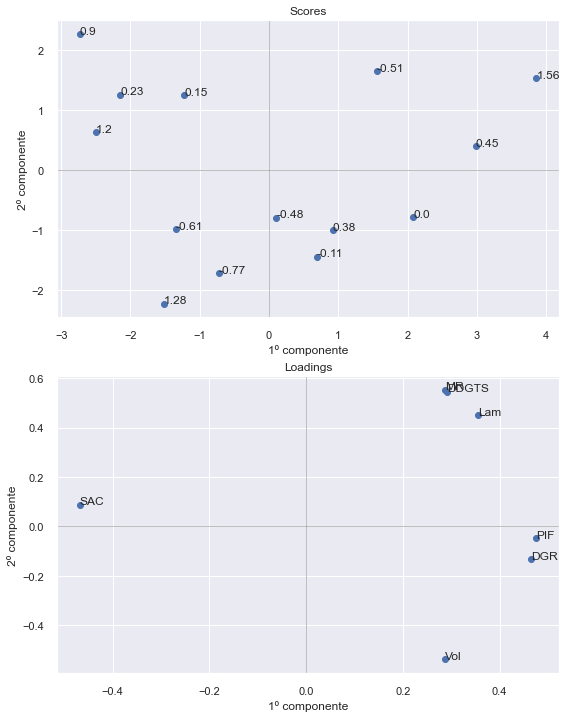

In [110]:
fig, ax = plt.subplots(2,1, figsize=(9,12))

# Gráfico dos scores
priComp = [t[0] for t in pls_chemometrics.x_scores_]
segComp = [t[1] for t in pls_chemometrics.x_scores_]

ax[0].axhline(color='gray', linewidth=0.5)
ax[0].axvline(color='gray', linewidth=0.5)
ax[0].scatter(priComp, segComp)
ax[0].set_title("Scores")
ax[0].set_xlabel("1º componente")
ax[0].set_ylabel("2º componente")

i = 0;
labels = df_chemometrics.iloc[:, 0].values
for l in pls_chemometrics.x_scores_:
  ax[0].text(x=l[0], y=l[1], s=labels[i])
  i += 1

# Gráfico dos loadings
priComp = [t[0] for t in pls_chemometrics.x_loadings_]
segComp = [t[1] for t in pls_chemometrics.x_loadings_]

ax[1].axhline(color='gray', linewidth=0.5)
ax[1].axvline(color='gray', linewidth=0.5)
ax[1].scatter(priComp, segComp)
ax[1].set_title("Loadings")
ax[1].set_xlabel("1º componente")
ax[1].set_ylabel("2º componente")

i = 1;
labels = df_chemometrics.columns
for l in pls_chemometrics.x_loadings_:
  plt.text(x=l[0], y=l[1], s=df_chemometrics.columns[i])
  i += 1

plt.show()